In [23]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import io
uploaded = files.upload()
excel_file = list(uploaded.keys())[0]
df = pd.read_excel(excel_file)
print("Archivo cargado y leido con exito")
print(df.head())

Saving Experimental water adsorption isotherms.xlsx to Experimental water adsorption isotherms (1).xlsx
Archivo cargado y leido con exito
            Type  Replicate  Temperature  Water activity  \
0  Roasted beans          1           25          0.0965   
1  Roasted beans          1           25          0.1467   
2  Roasted beans          1           25          0.2708   
3  Roasted beans          1           25          0.3576   
4  Roasted beans          1           25          0.4388   

   Moisture content (% wet basis)  Moisture content (% dry basis)  
0                            2.07                        2.113755  
1                            2.08                        2.124183  
2                            2.09                        2.134613  
3                            2.11                        2.155481  
4                            2.13                        2.176356  


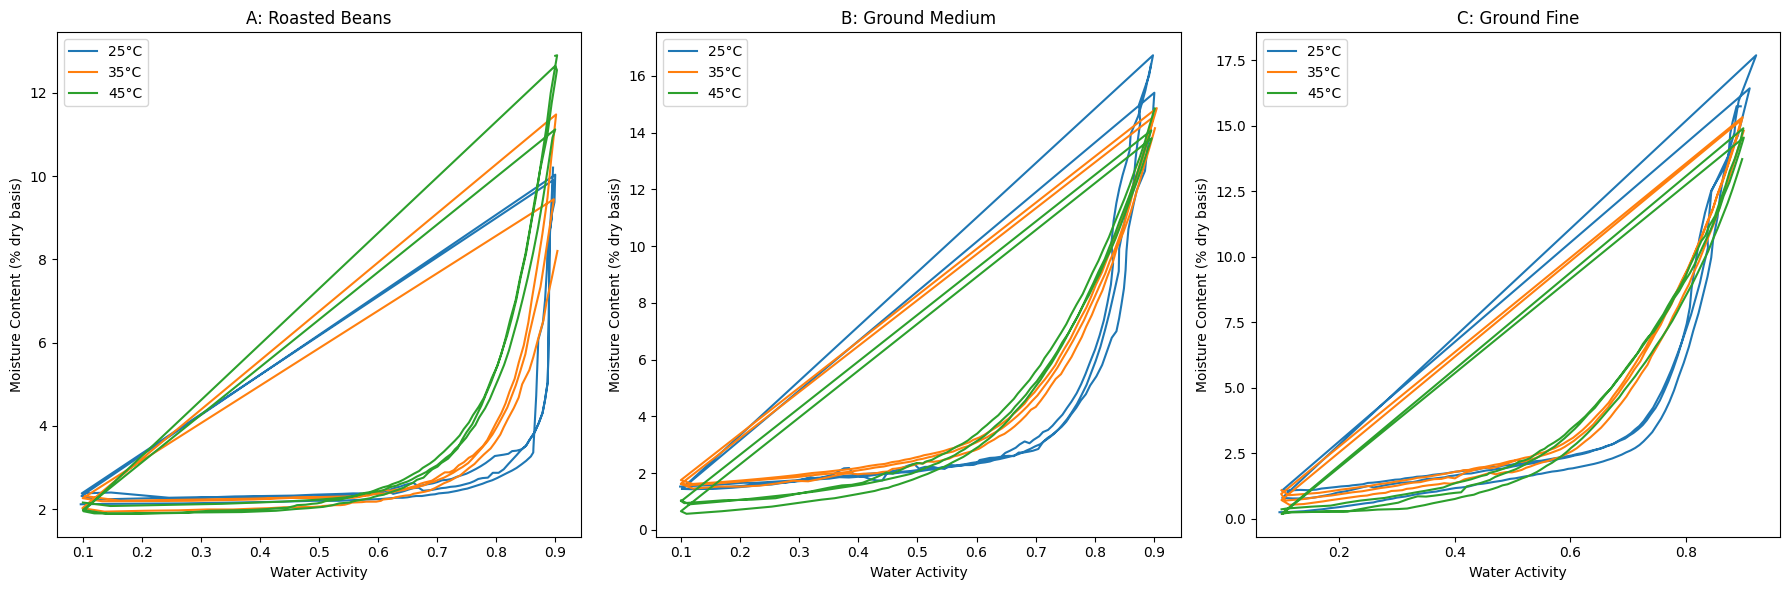

In [24]:
 roasted_beans_25 = df[(df['Type'] == 'Roasted beans') & (df['Temperature'] == 25)]
 roasted_beans_35 = df[(df['Type'] == 'Roasted beans') & (df['Temperature'] == 35)]
 roasted_beans_45 = df[(df['Type'] == 'Roasted beans') & (df['Temperature'] == 45)]
 ground_medium_25 = df[(df['Type'] == 'Ground-Medium') & (df['Temperature'] == 25)]
 ground_medium_35 = df[(df['Type'] == 'Ground-Medium') & (df['Temperature'] == 35)]
 ground_medium_45 = df[(df['Type'] == 'Ground-Medium') & (df['Temperature'] == 45)]
 ground_fine_25 = df[(df['Type'] == 'Ground-Fine') & (df['Temperature'] == 25)]
 ground_fine_35 = df[(df['Type'] == 'Ground-Fine') & (df['Temperature'] == 35)]
 ground_fine_45 = df[(df['Type'] == 'Ground-Fine') & (df['Temperature'] == 45)]
 plt.figure(figsize=(18, 6))
 plt.subplot(1, 3, 1)
 plt.plot(roasted_beans_25['Water activity'], roasted_beans_25['Moisture content (% dry basis)'], label='25°C')
 plt.plot(roasted_beans_35['Water activity'], roasted_beans_35['Moisture content (% dry basis)'], label='35°C')
 plt.plot(roasted_beans_45['Water activity'], roasted_beans_45['Moisture content (% dry basis)'], label='45°C')
 plt.xlabel('Water Activity')
 plt.ylabel('Moisture Content (% dry basis)')
 plt.title('A: Roasted Beans')
 plt.legend()
 plt.subplot(1, 3, 2)
 plt.plot(ground_medium_25['Water activity'], ground_medium_25['Moisture content (% dry basis)'], label='25°C')
 plt.plot(ground_medium_35['Water activity'], ground_medium_35['Moisture content (% dry basis)'], label='35°C')
 plt.plot(ground_medium_45['Water activity'], ground_medium_45['Moisture content (% dry basis)'], label='45°C')
 plt.xlabel('Water Activity')
 plt.ylabel('Moisture Content (% dry basis)')
 plt.title('B: Ground Medium')
 plt.legend()
 plt.subplot(1, 3, 3)
 plt.plot(ground_fine_25['Water activity'], ground_fine_25['Moisture content (% dry basis)'], label='25°C')
 plt.plot(ground_fine_35['Water activity'], ground_fine_35['Moisture content (% dry basis)'], label='35°C')
 plt.plot(ground_fine_45['Water activity'], ground_fine_45['Moisture content (% dry basis)'], label='45°C')
 plt.xlabel('Water Activity')
 plt.ylabel('Moisture Content (% dry basis)')
 plt.title('C: Ground Fine')
 plt.legend()
 plt.tight_layout()
 plt.show()

In [25]:
# Datos y optimización para Roasted Beans a 25°C
aw_data = roasted_beans_25['Water activity'].values
mc_data = roasted_beans_25['Moisture content (% dry basis)'].values

# Initial guess para Peleg y DLP
initial_guess_peleg = [1, 1, 1, 1]
initial_guess_dlp = [1, 1, 1, 1]

# Funciones de los modelos
def peleg(params, aw):
    b0, b1, b2, b3 = params
    return b0 * aw**b1 + b2 * aw**b3

def dlp(params, aw):
    b0, b1, b2, b3 = params
    x = np.log(-np.log(aw))
    return b0 + b1 * x + b2 * x**2 + b3 * x**3

# Función Chi-Cuadrado
def chi_squared(params, model, aw_data, mc_data):
    mc_predicted = model(params, aw_data)
    return np.sum((mc_data - mc_predicted)**2)

# Función para optimizar los parámetros
def optimize_parameters(aw_data, mc_data, model, initial_guess):
    result = minimize(chi_squared, initial_guess, args=(model, aw_data, mc_data), method='L-BFGS-B')
    return result.x

# Optimizar los parámetros
params_peleg = optimize_parameters(aw_data, mc_data, peleg, initial_guess_peleg)
params_dlp = optimize_parameters(aw_data, mc_data, dlp, initial_guess_dlp)

print("Roasted Beans a 25°C - Peleg Parameters:", params_peleg)
print("Roasted Beans a 25°C - DLP Parameters:", params_dlp)

# Calcular Chi-Cuadrado para cada modelo
chi_squared_peleg = chi_squared(params_peleg, peleg, aw_data, mc_data)
chi_squared_dlp = chi_squared(params_dlp, dlp, aw_data, mc_data)

print("Chi-Cuadrado Peleg:", chi_squared_peleg)
print("Chi-Cuadrado DLP:", chi_squared_dlp)

# Comparar los resultados
if chi_squared_peleg < chi_squared_dlp:
    print("El modelo Peleg describe mejor la curva.")
else:
    print("El modelo DLP describe mejor la curva.")

Roasted Beans a 25°C - Peleg Parameters: [4.67736573 3.68595058 4.67736573 3.68595058]
Roasted Beans a 25°C - DLP Parameters: [ 2.99268193  0.49557333 -1.66474737 -1.29914568]
Chi-Cuadrado Peleg: 347.8403968252859
Chi-Cuadrado DLP: 102.23440374689037
El modelo DLP describe mejor la curva.


In [29]:
%%file optimization.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>

// Definición de las funciones de los modelos
double peleg(double params[], double aw) {
    return params[0] * pow(aw, params[1]) + params[2] * pow(aw, params[3]);
}

double dlp(double params[], double aw) {
    double x = log(-log(aw));
    return params[0] + params[1] * x + params[2] * pow(x, 2) + params[3] * pow(x, 3);
}

// Función Chi-Cuadrado
double chi_squared(double params[], double (*model)(double[], double), double aw_data[], double mc_data[], int n) {
    double chi2 = 0.0;
    for (int i = 0; i < n; i++) {
        double mc_predicted = model(params, aw_data[i]);
        chi2 += pow(mc_data[i] - mc_predicted, 2);
    }
    return chi2;
}

// Método de descenso de gradiente (simplificado)
void gradient_descent(double aw_data[], double mc_data[], int n, double params[], double (*model)(double[], double), double learning_rate, int iterations) {
    double grad[4];
    for (int iter = 0; iter < iterations; iter++) {
        // Calcular gradientes (aproximación numérica)
        double delta = 0.0001;
        for (int i = 0; i < 4; i++) {
            double params_plus[4], params_minus[4];
            for (int j = 0; j < 4; j++) {
                params_plus[j] = params_minus[j] = params[j];
            }
            params_plus[i] += delta;
            params_minus[i] -= delta;

            grad[i] = (chi_squared(params_plus, model, aw_data, mc_data, n) - chi_squared(params_minus, model, aw_data, mc_data, n)) / (2 * delta);
        }

        // Actualizar parámetros
        for (int i = 0; i < 4; i++) {
            params[i] -= learning_rate * grad[i];
        }
    }
}

int main() {
    // Datos de ejemplo (deberías reemplazarlos con tus datos reales)
    double aw_data[] = {0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9};
    double mc_data[] = {2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8};
    int n = sizeof(aw_data) / sizeof(aw_data[0]);

    // Parámetros iniciales
    double initial_params_peleg[] = {1.0, 1.0, 1.0, 1.0};
    double initial_params_dlp[] = {1.0, 1.0, 1.0, 1.0};

    // Hiperparámetros para el descenso de gradiente
    double learning_rate = 0.001;
    int iterations = 1000;

    // Optimización para Peleg
    printf("Optimizando Peleg...\n");
    gradient_descent(aw_data, mc_data, n, initial_params_peleg, peleg, learning_rate, iterations);
    printf("Parámetros optimizados Peleg: %lf %lf %lf %lf\n", initial_params_peleg[0], initial_params_peleg[1], initial_params_peleg[2], initial_params_peleg[3]);

    // Optimización para DLP
    printf("Optimizando DLP...\n");
    gradient_descent(aw_data, mc_data, n, initial_params_dlp, dlp, learning_rate, iterations);
    printf("Parámetros optimizados DLP: %lf %lf %lf %lf\n", initial_params_dlp[0], initial_params_dlp[1], initial_params_dlp[2], initial_params_dlp[3]);

    return 0;
}



Overwriting optimization.c


In [27]:
%%bash
gcc optimization.c -o optimization -lm

In [28]:
%%bash
./optimization

Optimizando Peleg...
Parámetros optimizados Peleg: 1.377357 0.163519 1.377357 0.163519
Optimizando DLP...
Parámetros optimizados DLP: 2.123221 -0.329595 0.361017 0.170424
